In [1]:
import torch, torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torch.optim as optimizer

import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
print(torch.__version__)
! python --version

0.3.1.post3
Python 3.6.4 :: Anaconda, Inc.


In [3]:
#  CUDA
use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else '"cpu')
torch.cuda.set_device(0)
torch.cuda.get_device_name(0)

'Quadro K5200'

In [4]:
# Copied to make it work. DataLoader was giving errors
try:
    torch._utils._rebuild_tensor_v2
except AttributeError:
    def _rebuild_tensor_v2(storage, storage_offset, size, stride, requires_grad, backward_hooks):
        tensor = torch._utils._rebuild_tensor(storage, storage_offset, size, stride)
        tensor.requires_grad = requires_grad
        tensor._backward_hooks = backward_hooks
        return tensor
    torch._utils._rebuild_tensor_v2 = _rebuild_tensor_v2

In [5]:
# Hyperparameters 
num_epochs = 20
batchSize = 4

input_dim = 784
hidden_dim = 100
hidden2_dim = 64
output_dim = 10

In [6]:
# Transformation Function
transform_to = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [7]:
# Loading the data
trainData = torchvision.datasets.MNIST(root = './data', transform = transform_to,download = False)
trainLoader = torch.utils.data.DataLoader(trainData,batch_size=batchSize,shuffle = True)

testData = torchvision.datasets.MNIST(root = './data/', transform = transform_to,train = False, download = False)
testLoader = torch.utils.data.DataLoader(testData, batch_size=batchSize)

In [8]:
# Visualizing a few images

def show_img(image,labels = None):
    fig = plt.figure(figsize = (10,10))
    for i in range(len(image)):
        ax = plt.subplot(1,len(image),i+1)
        unnormalized_image = image[i]*0.3081 + 0.1307
        plt.imshow(unnormalized_image, cmap = 'gray')
        plt.axis('off')
        if labels is not None:
            plt.title(labels[i])

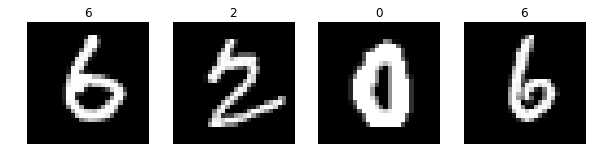

In [9]:
sample = next(iter(trainLoader))
image, label = sample
show_img(image.numpy().squeeze(),label.numpy())

In [10]:
# Defining a Network

class One_Hidden_Net(nn.Module):
    
    def __init__(self,i_dim,h_dim,o_dim):
        super().__init__()
        self.fc1 = nn.Linear(i_dim,h_dim)
        self.fc2 = nn.Linear(h_dim,o_dim)
        
    def forward(self,x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x)) # 784x100
        x = self.fc2(x) # 100x10
        return x

In [11]:
class Two_Hidden_Net(nn.Module):
    
    def __init__(self,i_dim,h1_dim,h2_dim,o_dim):
        super().__init__()
        self.fc1 = nn.Linear(i_dim,h1_dim)
        self.fc2 = nn.Linear(h1_dim,h2_dim)
        self.fc3 = nn.Linear(h2_dim,o_dim)
        

    def forward(self,x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
def train(network,optimizer,loss_func):
    loss_list = []
    for epoch in range(num_epochs):
#         running_loss = 0.0
        epoch_loss = []
        for i,data in enumerate(trainLoader):
            images,label = data
            images, label = Variable(images).cuda(), Variable(label).cuda()
        
            optimizer.zero_grad()
            output = network(images)
            
            loss = loss_func(output,label)
            epoch_loss.append(loss.data[0])
            loss.backward()
            optimizer.step()
            
#             running_loss += loss.data[0]
            
#             if one_layer and (i+1)%2000 == 0:
#                 avg_loss = running_loss/2000
#                 print(f'Epoch: {epoch+1}, Iteration: {i+1}, Loss: {avg_loss:.3f}')
#                 running_loss = 0.0
        loss_list.append(np.array(epoch_loss).mean())   
        print(f'Epoch: {epoch+1}, Loss: {np.array(epoch_loss).mean():.3f}')
    
    print('Finished Training')
    return loss_list
            

In [13]:
def predict_on_test(network,iterator,model_name):
    correct = 0
    total = 0
    for data in iterator:
        images,labels = data
        images = Variable(images).cuda()
        outputs = network(images)
        class_scores,preds = torch.max(outputs.data,1)
        total += len(labels)
        correct += (preds == labels.cuda()).sum()
        
    print(f'Accuracy on Test Data using a {model_name} is {correct*100/total:.2f}%')

    
def plot_train_loss(losses,title):
    plt.plot(losses)
    plt.title(title)
    plt.xlabel('No. of Epochs')
    plt.ylabel('Training Loss')

<b> Using One Hidden Layer Network

In [14]:
model = One_Hidden_Net(input_dim,hidden_dim,output_dim).cuda()

In [15]:
model.eval()

One_Hidden_Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [16]:
# Setting hyperparameters

loss_criterion = nn.CrossEntropyLoss()
opt = optimizer.SGD(model.parameters(),lr = 0.01)

In [17]:
train_loss = train(model,opt, loss_criterion)

Epoch: 1, Loss: 0.227
Epoch: 2, Loss: 0.098
Epoch: 3, Loss: 0.070
Epoch: 4, Loss: 0.054
Epoch: 5, Loss: 0.041
Epoch: 6, Loss: 0.034
Epoch: 7, Loss: 0.026
Epoch: 8, Loss: 0.020
Epoch: 9, Loss: 0.016
Epoch: 10, Loss: 0.012
Epoch: 11, Loss: 0.009
Epoch: 12, Loss: 0.007
Epoch: 13, Loss: 0.005
Epoch: 14, Loss: 0.003
Epoch: 15, Loss: 0.003
Epoch: 16, Loss: 0.002
Epoch: 17, Loss: 0.002
Epoch: 18, Loss: 0.001
Epoch: 19, Loss: 0.001
Epoch: 20, Loss: 0.001
Finished Training


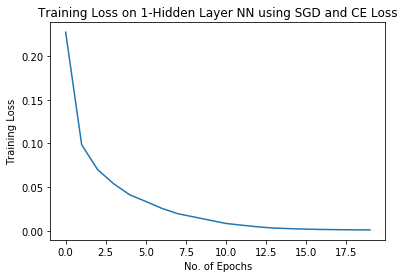

In [18]:
plot_train_loss(train_loss,'Training Loss on 1-Hidden Layer NN using SGD and CE Loss')

In [19]:
predict_on_test(model,testLoader,'1-Hidden Layer NN')

Accuracy on Test Data using a 1-Hidden Layer NN is 98.25%


<b> Using Two Hidden Layer Network

In [20]:
model_2 = Two_Hidden_Net(input_dim,hidden2_dim,hidden2_dim,output_dim).cuda()

In [21]:
model_2.eval()

Two_Hidden_Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [22]:
num_epochs = 30

In [23]:
loss_criterion2 = nn.CrossEntropyLoss()
opt2 = optimizer.SGD(model_2.parameters(),lr = 0.01)

In [24]:
train2_loss = train(model_2,opt2,loss_criterion2)

Epoch: 1, Loss: 0.255
Epoch: 2, Loss: 0.114
Epoch: 3, Loss: 0.082
Epoch: 4, Loss: 0.066
Epoch: 5, Loss: 0.054
Epoch: 6, Loss: 0.047
Epoch: 7, Loss: 0.039
Epoch: 8, Loss: 0.036
Epoch: 9, Loss: 0.029
Epoch: 10, Loss: 0.023
Epoch: 11, Loss: 0.021
Epoch: 12, Loss: 0.019
Epoch: 13, Loss: 0.019
Epoch: 14, Loss: 0.015
Epoch: 15, Loss: 0.016
Epoch: 16, Loss: 0.010
Epoch: 17, Loss: 0.009
Epoch: 18, Loss: 0.012
Epoch: 19, Loss: 0.009
Epoch: 20, Loss: 0.009
Epoch: 21, Loss: 0.009
Epoch: 22, Loss: 0.008
Epoch: 23, Loss: 0.007
Epoch: 24, Loss: 0.007
Epoch: 25, Loss: 0.004
Epoch: 26, Loss: 0.003
Epoch: 27, Loss: 0.005
Epoch: 28, Loss: 0.006
Epoch: 29, Loss: 0.008
Epoch: 30, Loss: 0.008
Finished Training


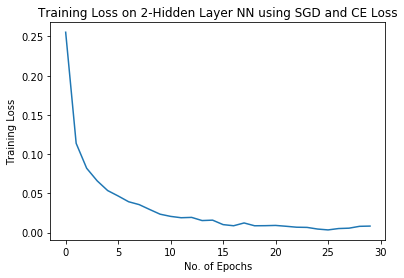

In [25]:
plot_train_loss(train2_loss,title = 'Training Loss on 2-Hidden Layer NN using SGD and CE Loss')

In [26]:
predict_on_test(model_2,testLoader,'2-Hidden Layer NN')

Accuracy on Test Data using a 2-Hidden Layer NN is 97.82%
